# Yelp text data

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import seaborn as sns
import dask.dataframe as dd
import spacy
from spacy_readability import Readability
from dask import delayed
from dask_ml.model_selection import train_test_split
from gensim.models import Word2Vec, Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim.corpora import Dictionary
from gensim.similarities import Similarity
from gensim.models import LsiModel
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE
# from sklearn.model_selection import train_test_split
# from gensim.test.utils import common_dictionary, common_corpus
# from tqdm import tqdm

sns.set_style('darkgrid')
laptop = '/media/seapea/Blade HDD/_Storage/Data/yelp_dataset/'
tower = '/run/media/seapea/HDD1TB_1/SharedSpace/_Large_datasets/Yelp/'
nlp = spacy.load('en_core_web_md', disable=['tagger', 'ner'])
read = Readability(nlp)
nlp.add_pipe(read, last=True)
%matplotlib inline

OSError: [E050] Can't find model 'en_core_web_md'. It doesn't seem to be a shortcut link, a Python package or a valid path to a data directory.

In [ ]:
# Read in a sample of the larger dataset for necessary trial and error
df0 = pd.read_parquet(laptop + 'parquet/part.0.parquet')#.set_index('review_id')
df1 = pd.read_parquet(laptop + 'parquet/part.1.parquet')#.set_index('review_id')
df2 = pd.read_parquet(laptop + 'parquet/part.2.parquet')#.set_index('review_id')
df3 = pd.read_parquet(laptop + 'parquet/part.3.parquet')#.set_index('review_id')
df4 = pd.read_parquet(laptop + 'parquet/part.4.parquet')#.set_index('review_id')

# Let's concat and convert to Dask
df = pd.concat([df0, df1, df2, df3, df4], axis=0)
del(df0, df1, df2, df3, df4)
ddf = dd.from_pandas(df, chunksize=2**12)

In [2]:
# usr = dd.read_json('G:/SharedSpace/_Large_datasets/Yelp/user.json', lines=True, blocksize=2**28)
# biz = dd.read_json('E:/_Large_datasets/Yelp/business.json', lines=True)#, blocksize=2**28)

rev = dd.read_json(laptop + 'review.json', 
                   lines=True, blocksize=2**22) # lower blocksize (i.e. 2*22) made this work in Linux
rev = rev.drop(['funny', 'cool', 'date', 'user_id', 'business_id'], axis=1)
rev = rev.drop_duplicates(subset='text')
# rev = rev.set_index('review_id')
# rev.to_parquet(laptop + 'parquet/')
rev.head()

review_id  stars  useful  \
0  Q1sbwvVQXV2734tPgoKj4Q      1       6   
1  GJXCdrto3ASJOqKeVWPi6Q      5       0   
2  2TzJjDVDEuAW6MR5Vuc1ug      5       3   
3  yi0R0Ugj_xUx_Nek0-_Qig      5       0   
4  11a8sVPMUFtaC7_ABRkmtw      1       7   

                                                text  
0  Total bill for this horrible service? Over $8G...  
1  I *adore* Travis at the Hard Rock's new Kelly ...  
2  I have to say that this office really has it t...  
3  Went in for a lunch. Steak sandwich was delici...  
4  Today was my second out of three sessions I ha...

## Dask challenges
Throughout this project, I have found it to be very painful working with Dask. It is not covered in the course anywhere, despite being a more realistic work environment where too much data exists to analyze things in memory. Arithmetic computations and other analyses across the Dask dataframe chunks pose challenges we haven't seen when operating only in memory.

Some basic issues encountered with Dask include:

- Boolean indexing
- .loc slicing (returning many values)
- spaCy pipelines (memory allocation)
- Word2Vec conversions (memory allocation)
- Basic computations (very long turn around)

Because of these limitations, some of the work and discovery efforts behind the scenes might not be displayed in the notebook.

### Distribution of review ratings
Let's try some basic Dask computations, verifying integrity and observing the distribution of review ratings.

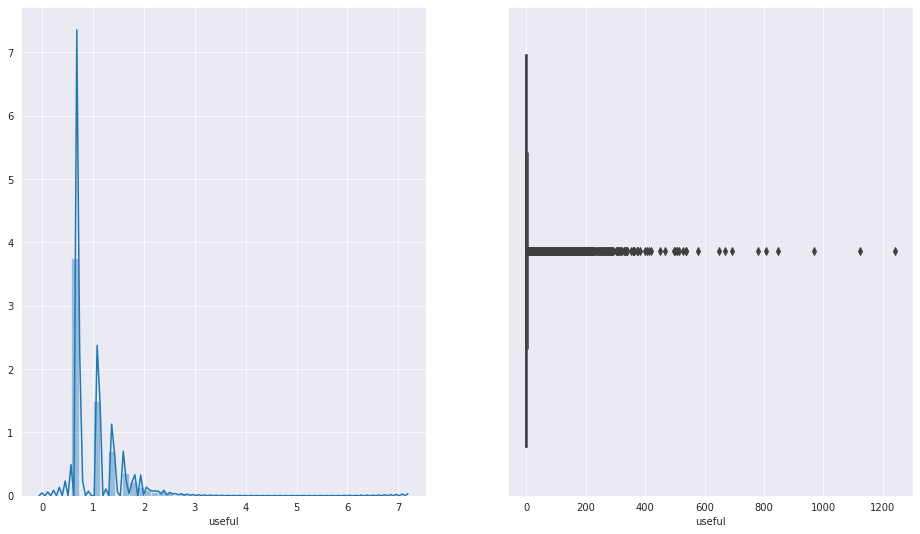

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,9))
sns.distplot(np.log((rev.useful + 2).compute()), ax=ax1)
sns.boxplot(rev.useful.compute(), ax=ax2)

In [51]:
rev[rev.useful == rev.useful.max().compute()].text.compute()

203142    Dinner for 1.\n\n- Preface\nI went to Amy's Ba...
Name: text, dtype: object

### Approaching parsing of vast text
Another simple task to test the library - we will try the TfidfVectorizer. I'm working with this instead of the regular counter because it will keep our values between zero and one for the visualization I want to map.

In [7]:
@delayed
def ret_count(ddf):
    vec = TfidfVectorizer(stop_words='english', ngram_range=(1,2), max_features=30)
    X = vec.fit_transform(ddf)
    names = vec.get_feature_names()
    return X, names

ddf, names = ret_count(rev.text).compute()
print(names)

['best', 'came', 'chicken', 'come', 'definitely', 'did', 'didn', 'don', 'food', 'friendly', 'good', 'got', 'great', 'just', 'like', 'little', 'love', 'nice', 'order', 'ordered', 'people', 'place', 'really', 'restaurant', 'service', 'staff', 'time', 'try', 've', 'went']


### Success! 
Our vectorizer didn't overload the system!

Unfortunately, the counts are exceedingly high and overpower the other observations making this unhelpful.

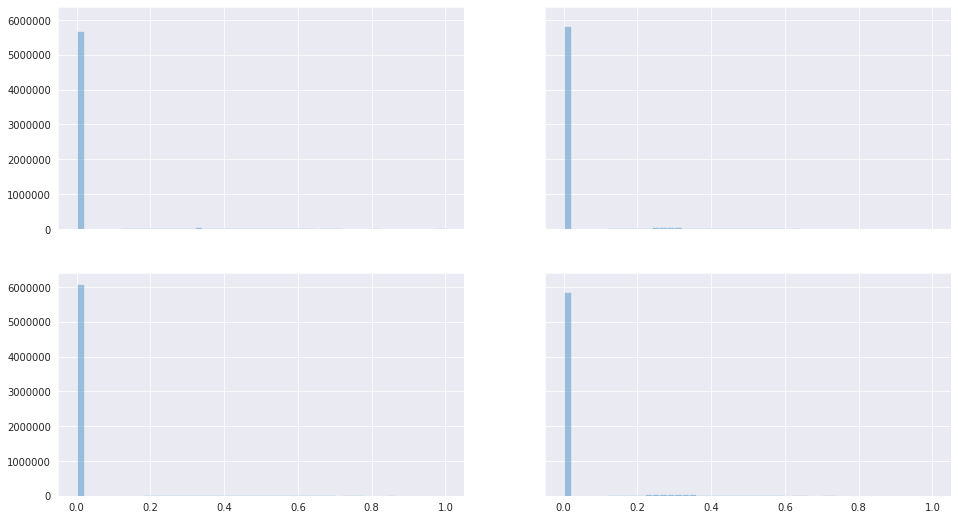

In [9]:
def top4(val, ax):
    sns.distplot(ddf.todense()[:,val].reshape(1,-1), kde=True, ax=ax)
    
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16,9), sharex=True, sharey=True) 
axes = [ax1, ax2, ax3, ax4]

for val, ax in zip(range(4), axes):
    top4(val, ax)

# Dask hurdles overcome
After some hours of troubleshooting (not shown in project), I comfortable with the distributed dataframes

## Other memory improvements - Previous attempts at spaCy
In a previous project, I limited my vocabulary and text subset to one million words as spaCy throws an error when too large a vocabulary exists for use in memory. I have since discovered a lazy computation design for this exists within spaCy called the pipe. This allows spaCy to batch the documents and prevent breaking memory constraints. This has been a helpful discovery.

### Steps to find review value
The steps below will be the analyses we take to find explicit value in reviews.

#### Graph the count of words
Maybe the frequency of certain words is more prevalent in more valuable reviews

#### Word combinations?
Are there combinations of words (phrases) that exist frequently?

#### Readability
Might be a factor

#### Length of review
Might also

#### Combining the metrics
Also checking if industries respond differently

In [345]:
'''@delayed
def ret_count(ddf):
    vec = CountVectorizer(stop_words='english', ngram_range=(1,2), max_features=50)
    X = vec.fit_transform(ddf)
    names = vec.get_feature_names()
    return X, names

ddf, names = ret_count(rev.text).compute()
print(names)'''

['amazing', 'best', 'better', 'came', 'chicken', 'come', 'day', 'definitely', 'delicious', 'did', 'didn', 'don', 'experience', 'food', 'friendly', 'going', 'good', 'got', 'great', 'just', 'know', 'like', 'little', 'love', 'make', 'menu', 'new', 'nice', 'night', 'order', 'ordered', 'people', 'place', 'pretty', 'really', 'recommend', 'restaurant', 'right', 'said', 'say', 'service', 'staff', 'sure', 'time', 'try', 've', 'wait', 'want', 'way', 'went']


## Crunching bag of words, need lemmas
We will try this again with some preprocessing - the benefits of lemmatization would increase the diversity of words selected for features.

In [3]:
# Basic text cleaning
def fix_nl(mytext):
    text = re.sub(r'\n\n', '', mytext)
    text = re.sub(r'\n', '', text)
    final = re.sub(r'  ', ' ', text)
    return final

# Basic lemmatize function
def lemma_sent(sent):
    return ' '.join(word.lemma_.lower() for word in sent if not word.is_punct and not word.is_stop)

@delayed
def process_n_count(series):
    series = series.apply(fix_nl)
    spaCy_text = nlp.pipe(series)
    vec = CountVectorizer(stop_words='english', ngram_range=(1,2), max_features=300)
    vec.fit_transform([lemma_sent(text) for text in spaCy_text])
    return vec
    
@delayed
def test(series, vec):
    series = series.apply(fix_nl)
    spaCy_test = nlp.pipe(series)
    X_new = vec.transform(series)
    return X_new

In [412]:
# This cell will test the steps of my approach against a much smaller dataframe
df.text = df.text.apply(fix_nl)
new_txt = list(nlp.pipe(df.iloc[:5000].text))
cvec = CountVectorizer(stop_words='english', max_features=100)
cvec.fit_transform([lemma_sent(txt) for txt in new_txt])

<5000x100 sparse matrix of type '<class 'numpy.int64'>'
	with 52872 stored elements in Compressed Sparse Row format>

In [426]:
cvec.transform([lemma_sent(txt) for txt in list(nlp.pipe(df.iloc[5000:6000].text))])

<1000x100 sparse matrix of type '<class 'numpy.int64'>'
	with 10395 stored elements in Compressed Sparse Row format>

### Vectorized text transformation
The transformation appears to work against new data! We will now attempt the same process against the entire 'rev' dataset. 

Note: This is the same tactic as we tried above (commented out), but we are hoping for better, more accurate results since we are reducing the text to lemmas and cleaning it more.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(rev[['text', 'useful']], rev.useful, test_size=0.5)

# Had to run this training and compute command after emptying as much in memory as possible
# new_vec = process_n_count(X_train).compute()

from joblib import dump, load
# dump(new_vec, "vec.joblib")
new_vec = load('vec.joblib')

myX = test(X_test.text, new_vec).compute()

<BarContainer object of 300 artists>

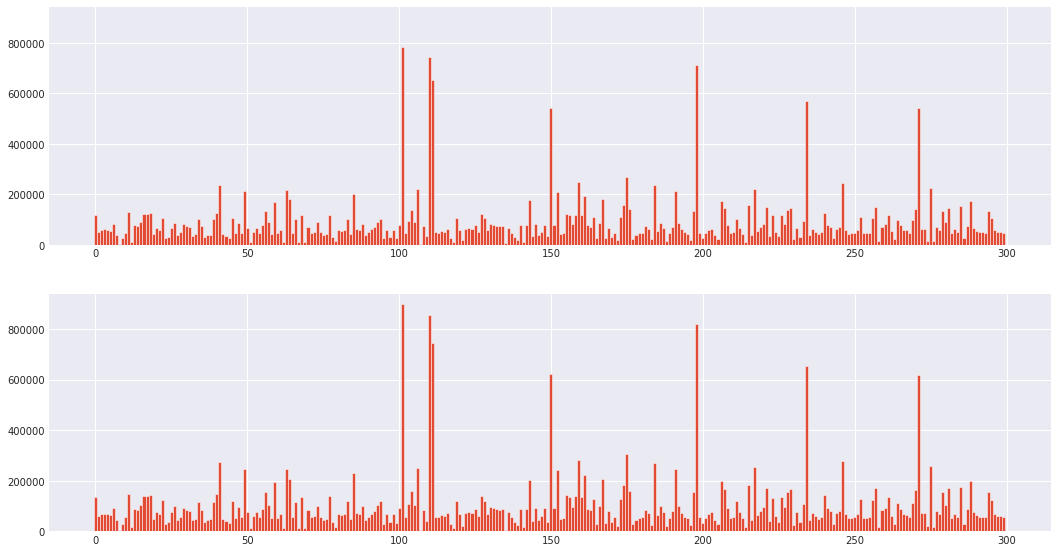

In [69]:
sns.set_style('darkgrid')
# plt.style.use('ggplot')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,9), sharey=True)
myInd1 = X_train[X_train.useful > 0].index.compute()
myInd0 = X_train[X_train.useful == 0].index.compute()

ax1.bar(range(300), np.array(myX[myInd1].sum(axis=0)).tolist()[0], width=1)
ax2.bar(range(300), np.array(myX[myInd0].sum(axis=0)).tolist()[0], width=1)

### Visual differences 
Visually, we are seeing striking similarities between

### Readability

In [ ]:
# Heatmap



In [28]:
nlp.pipe(rev.text)

### Doc2Vec: How to handle the large corpus
After some trial, error, and research, it is my conclusion that the model computation will not differ between one large or several chunks. This stems from a blog written by the library's author - Radim Rehurek - discussing multiprocessing for faster running times. If the content can be processed in parallel, it is not requiring information from the entire corpus and can be run in pieces.

### Verifying training updates
We will verify if this can be done below. Within gensim, we can access the document and word vectors after training updates to see if the model updates.

In [427]:
# Tagging function with delayed capability
@delayed
def tag(df):
    df.text = df.text.apply(fix_nl)
    tags = []
    for i, doc in enumerate(nlp.pipe(df.text, disable=['ner', 'parser'])):
        mylist = [chunk.lemma_.lower() for chunk in doc if not chunk.is_punct and not chunk.is_stop]
        tags.append(TaggedDocument(mylist, [i]))
        
    vec = Doc2Vec(min_count=1)
    vec.build_vocab(tags)
    
    return vec, tags

In [27]:
vec1, tags1 = tag(ddf).compute()
test_arr = vec1.docvecs[0]
vec1.docvecs.most_similar(0, topn=5)

[(17033, 0.38854920864105225),
 (23295, 0.3664354085922241),
 (12518, 0.3616259694099426),
 (12915, 0.3600383400917053),
 (14743, 0.35090503096580505)]

In [20]:
vec1.wv.most_similar(tags1[0][0], topn=5)

[('cantor', 0.3950194716453552),
 ('allllways', 0.39479339122772217),
 ('chitown', 0.3757461905479431),
 ('fantastico', 0.35876384377479553),
 ('sick', 0.35497692227363586)]

In [28]:
vec2, tags2 = tag(rev).compute()
vec1.train(tags2, len(tags1) + len(tags2), epochs=5)
test_arr1 = vec1.docvecs[0]
vec1.docvecs.most_similar(0, topn=5)

[(17033, 0.38854920864105225),
 (23295, 0.3664354085922241),
 (12518, 0.3616259694099426),
 (12915, 0.3600383400917053),
 (14743, 0.35090503096580505)]

In [22]:
vec1.wv.most_similar(tags1[0][0], topn=5)

[('apartment', 0.9960299134254456),
 ('spicy', 0.9960122108459473),
 ('oil', 0.9959917664527893),
 ('dry', 0.9959776401519775),
 ('b', 0.9959765672683716)]

In [31]:
# Every single value in array is equal
sum(test_arr != test_arr1)

0

### Basic retraining failed
It appears the document vectors within the model are *not* returning different results when compared with the most_similar method. I did see this somewhere but wanted to verify. We can verify the document vectors themselves are not different, as shown when comparing the test arrays.

Moving forward, some Google queries and documentation digging show Doc2Vec does not allow the same training update approach that word vectors allow, as I suspected. We will have to work with the word embeddings instead.

### Similarity_matrix
We are actually able to 

#### Steps
1. Create gensim Dictionary
2. Create corpus of tuples
3. Create LSI model with each input
4. Query and fit a Dictionary object into the vector space

Where does model.wv.similarity_matrix fit in?

In [71]:
vec = CountVectorizer(max_features=100, ngram_range=(1,2), stop_words='english')

@delayed
def vectorize(df):
    return vec.fit_transform(df.text)

it = vectorize(rev).compute()

KeyboardInterrupt: 

In [ ]:
# sklearn tool faster than [fix_nl(txt).split] for txt in rev.text.compute()])
mydct = Dictionary([vec.get_feature_names()])
mycorp = [mydct.doc2bow(fix_nl(txt).split()) for txt in rev.text.compute()]
mylsi = LsiModel(mycorp, id2word=mydct, num_topics=100)
mylsi[mydct.doc2bow(fix_nl(list(rev.text.loc[0].compute())[0]).split())]

In [287]:
# sklearn tool faster than [fix_nl(txt).split] for txt in rev.text.compute()])
mydct = Dictionary([vec.get_feature_names()])
mycorp = [mydct.doc2bow(fix_nl(txt).split()) for txt in rev.text.compute()]
mylsi = LsiModel(mycorp, id2word=mydct, num_topics=2)
mylsi[mydct.doc2bow(fix_nl(list(rev.text.loc[0].compute())[0]).split())]

[(0, 0.8622897373758738), (1, -0.7724632421528443)]

In [290]:
mybow = [mydct.doc2bow(fix_nl(list(rev.text.loc[i].compute())[0]).split()) for i in range(len(rev))]
mylsa = [mylsi[bow] for bow in mybow]

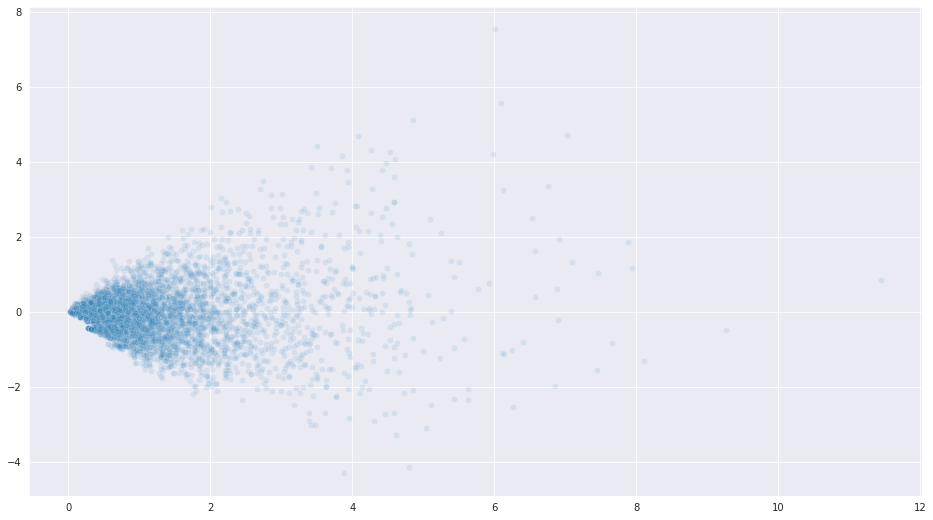

In [354]:
x = []
y = []
for i, val in enumerate(mylsa):
    try:
        x.append(val[0][1])
    except:
        pass
    try:
        y.append(val[1][1])
    except:
        pass

fig, ax = plt.subplots(figsize=(16,9))
sns.scatterplot(x=x, y=y, alpha=0.1)

In [342]:
tsne = TSNE()
TSNE.fit_transform(mylsi)

7.533877018931459

## Build two separate LSI models
Compare the text to both and check soft cosine similarity?